**Market Basket Analysis using Association Rules**

- This notebook covers Market Basket Analysis using Association Rules on grocery data :[The Instacart Online Grocery Shopping Dataset 2017](https://www.instacart.com/datasets/grocery-shopping-2017)
- The output of this file generates a table with pairs of *Antecedent-Consequent* food items under certain *Support*,*Confidence*, and *Lift* conditions.

In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import sys

from apyori import apriori


In [2]:
#funtion to return the size of a pandas dataframe in MB

def size(df):
    return '{0:.2f} MB'.format(sys.getsizeof(df) / (1024 * 1024))

In [3]:
#importing data

df_orders = pd.read_csv('/content/order_products__prior.csv')
df_products = pd.read_csv('/content/products.csv')

In [4]:
print('Order Data sample')
print(df_orders.head())

Order Data sample
   order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0


In [5]:
print('Products sample')
print(df_products.head())

Products sample
   product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13  


In [6]:
# joining Order and Product data to obtain product names for each of the orders

df_orders_product = pd.merge(df_orders[['order_id', 'product_id']],
                             df_products[['product_name', 'product_id']],
                             on='product_id', how='left')\
                             .drop(columns = ['product_id'])
print(df_orders_product.head())

   order_id           product_name
0         2     Organic Egg Whites
1         2  Michigan Organic Kale
2         2          Garlic Powder
3         2         Coconut Butter
4         2      Natural Sweetener


In [7]:
print(df_orders_product.shape)
print(size(df_orders_product))

(32434489, 2)
3035.86 MB


In [8]:
# creating a new dataframe to collect most bought food items along with their order count

popular_products = df_orders_product.groupby(['product_name'])['order_id']\
                                    .count()\
                                    .reset_index(name='count')\
                                    .sort_values(['count'], ascending=False)\
                                    .reset_index()
top_10_popular_products = popular_products.head(10)
print('10 most bought food items')
print(top_10_popular_products)

   index            product_name   count
0   3676                  Banana  472565
1   3471  Bag of Organic Bananas  379450
2  31920    Organic Strawberries  264683
3  28840    Organic Baby Spinach  241921
4  30297    Organic Hass Avocado  213584
5  28804         Organic Avocado  176815
6  22413             Large Lemon  152657
7  42904            Strawberries  142951
8  23420                   Limes  140627
9  32478      Organic Whole Milk  137905


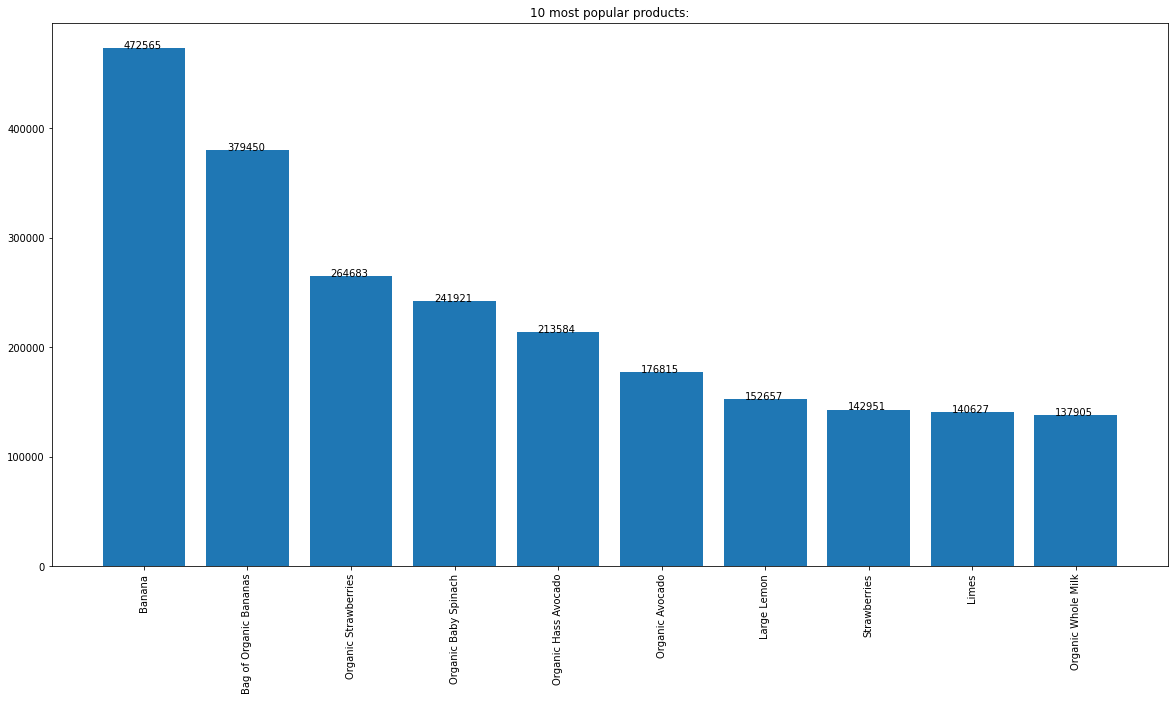

In [9]:
# visualizing 10 most bought food items

names = list(top_10_popular_products['product_name'])
values = list(top_10_popular_products['count'])
plt.subplots(figsize = (20,10))
bars = plt.bar(range(len((top_10_popular_products['product_name']))),
               values,
               tick_label=names)
plt.title('10 most popular products:')
for bar in bars:
    yval = bar.get_height()
    plt.text((bar.get_x()+0.2), yval + .01, yval)
    plt.xticks(rotation=90)
plt.show()

In [10]:
# collecting all food items in an order and saving them into a list 

df_cart_order = df_orders_product.groupby(['order_id'])['product_name']\
                       .apply(list)\
                       .reset_index(name='cart_products')
df_cart_order = df_cart_order[:-1]
print(df_cart_order.head())
print(df_cart_order.tail())
print(size(df_cart_order))

   order_id                                      cart_products
0         2  [Organic Egg Whites, Michigan Organic Kale, Ga...
1         3  [Total 2% with Strawberry Lowfat Greek Straine...
2         4  [Plain Pre-Sliced Bagels, Honey/Lemon Cough Dr...
3         5  [Bag of Organic Bananas, Just Crisp, Parmesan,...
4         6  [Cleanse, Dryer Sheets Geranium Scent, Clean D...
         order_id                                      cart_products
3214868   3421078  [Organic Gala Apples, Banana, Gluten Free Pean...
3214869   3421079                                    [Moisture Soap]
3214870   3421080  [Organic Whole Milk, Vanilla Bean Ice Cream, O...
3214871   3421081  [Hint of Lime Flavored Tortilla Chips, Classic...
3214872   3421082  [Fresh 99% Lean Ground Turkey, Original Spray,...
548.79 MB


In [11]:
# applying association rules on lists of food items across multiple purchase orders

transactions = df_cart_order['cart_products']
a_rules = apriori(transactions, min_support=0.01, min_confidance=0.4, min_lift=1.5, max_length=3)
list_rules = list(a_rules)
df_rules = pd.DataFrame(list_rules)
display(df_rules.head())

,items,support,ordered_statistics
0,"(Bag of Organic Bananas, Organic Baby Spinach)",0.015668,"[((Bag of Organic Bananas), (Organic Baby Spin..."
1,"(Organic Hass Avocado, Bag of Organic Bananas)",0.019391,"[((Bag of Organic Bananas), (Organic Hass Avoc..."
2,"(Bag of Organic Bananas, Organic Raspberries)",0.012599,"[((Bag of Organic Bananas), (Organic Raspberri..."
3,"(Bag of Organic Bananas, Organic Strawberries)",0.019170,"[((Bag of Organic Bananas), (Organic Strawberr..."
4,"(Large Lemon, Banana)",0.012716,"[((Banana), (Large Lemon), 0.08650680119518203..."


In [12]:
# extracting elements from df_rules into different lists

os_col1 = []
os_col2 = []
os_col3 = []
os_col4 = []

for i in range(df_rules.shape[0]):
    list_flat = df_rules['ordered_statistics'][i][0]
    os_col1.append(list(list_flat[0]))
    os_col2.append(list(list_flat[1]))
    os_col3.append(list_flat[2])
    os_col4.append(list_flat[3])
    
support = list(df_rules['support'])  

In [13]:
# Combining the lists computed above into a tabular pandas dataframe

df_result = pd.concat([pd.DataFrame(os_col1, columns=['Antecedent']),
                       pd.DataFrame(os_col2, columns=['Consequent']),
                       pd.DataFrame(support, columns=['Support']),
                       pd.DataFrame(os_col3, columns=['Confidence']),
                       pd.DataFrame(os_col4, columns=['Lift'])],
                      axis=1)
display(df_result.head())

,Antecedent,Consequent,Support,Confidence,Lift
0,Bag of Organic Bananas,Organic Baby Spinach,0.015668,0.132750,1.764107
1,Bag of Organic Bananas,Organic Hass Avocado,0.019391,0.164293,2.472944
2,Bag of Organic Bananas,Organic Raspberries,0.012599,0.106741,2.503775
3,Bag of Organic Bananas,Organic Strawberries,0.019170,0.162414,1.972701
4,Banana,Large Lemon,0.012716,0.086507,1.821786


In [14]:
df_result.to_csv('rules_results.csv', index = None)